### Install and load the required packages

In [2]:
# Install required packages
from distutils.dir_util import copy_tree
copy_tree("../CapstoneProject/results/lib", "../CapstoneProject/Working/")
!pip install efficientnet_pytorch

import os
import csv
import albumentations as A
from glob import glob
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import sys
sys.path.append("../CapstoneProject/results/lib")

import torch
from torch.utils.data import DataLoader

### Settings

In [3]:
from data import CLASSES, format_prosthesis_name
from metrics import print_metrics
from plots import plot_confusion_matrix
from datasets import OrthonetClassificationDataset
from models import get_unet, CLASSIFIER_MODEL_GENERATORS
from training import load_classifier_transforms
from testing import eval_seg, eval_unetseg, eval_ensemble, write_predictions_to_csv

In [4]:
# Paths
CSV_TEST = "../CapstoneProject/archive/test.csv"
MODEL_DIR = "../CapstoneProject/Orthonet_Models"
DATA_PATH = "../CapstoneProject/archive/orthonet data/orthonet data new"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BS_TEST = 4
N_WORKERS = 1

### Load dataset and show statistics

In [5]:
_, test_transforms = load_classifier_transforms()
ds_test = OrthonetClassificationDataset('test', CSV_TEST, DATA_PATH, test_transforms)
dl_test = DataLoader(ds_test, BS_TEST, shuffle=False, num_workers=N_WORKERS, pin_memory=True)

ds_test.stats()

class_names = [format_prosthesis_name(c) for c in CLASSES]

M
A
P
Found 180 test samples from ../CapstoneProject/archive/test.csv

156 unique patients
Class                                             Number of samples
Knee_SmithAndNephew_Legion2                       15
Hip_JRIOrtho_FurlongEvolution_NilCol              15
Hip_DepuySynthes_Corail_NilCol                    15
Hip_Stryker_Exeter                                15
Knee_ZimmerBiomet_Oxford                          15
Knee_Depuy_Synthes_Sigma                          15
Hip_SmithAndNephew_Polarstem_NilCol               15
Knee_SmithAndNephew_GenesisII                     15
Hip_DepuySynthes_Corail_Collar                    15
Hip_JRIOrtho_FurlongEvolution_Collar              15
Hip_Stryker_AccoladeII                            15
Hip_SmithAndNephew_Anthology                      15




# Inference example

Please set the variable `URL_RADIOGRAPH` to the web address of the image you wish to perform inference on.

For transparency, the full inference code is shown below rather than made functional as in the evaluation sections above.

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from urllib.request import urlopen
from PIL import Image

# Set a web link to the radiograph you're interested in classifying
#URL_RADIOGRAPH = "https://james.dev/orthonet_example.png"
URL_RADIOGRAPH = "C:/Users/aksha/Desktop/a.png"
# Load the models
# Simple classifier
#_, model_2d_type, model_2d_path = best_2d_model
model_2d = CLASSIFIER_MODEL_GENERATORS["efficientnet"](n_in=1, n_out=len(CLASSES)).to(DEVICE)
model_2d.load_state_dict(torch.load("C:/Users/aksha/Desktop/CapstoneProject/Working/efficientnet_215_0.0944893.pt",map_location=torch.device('cpu'))['state_dict'])
model_2d.eval()


unet_path = "C:/Users/aksha/Desktop/CapstoneProject/Working/seg_unet_192_0.9000270.pt"
unet_model = get_unet(1, 1).to(DEVICE)
unet_model.load_state_dict(torch.load(unet_path,map_location=torch.device('cpu'))['state_dict'])
unet_model = unet_model.eval()
clahe_transform = A.Compose([A.CLAHE(p=1)])



model_seg = CLASSIFIER_MODEL_GENERATORS["wideresnet50"](n_in=2, n_out=len(CLASSES)).to(DEVICE)
model_seg.load_state_dict(torch.load("C:/Users/aksha/Desktop/CapstoneProject/Working/wideresnet50.pt",map_location=torch.device('cpu'))['state_dict'])
model_seg.to(DEVICE).eval()


# Load the image
img = np.array(Image.open(URL_RADIOGRAPH))

# Process image to pass into network
x = test_transforms(image=img)['image'] / 255.
x = torch.from_numpy(x).float().unsqueeze_(0).unsqueeze_(0).to(DEVICE)

with torch.no_grad():
    # Simple classifier
    y_pred_classifier = model_2d(x)
    
    mask = torch.sigmoid(unet_model(x)) > 0.5
    x_m = x.clone()
    x_m[~mask] = 0
    x = torch.cat((x_m, x), dim=1)
    
    # Contrast-limited adaptive histogram equalisation
    x[0,0] = torch.tensor(clahe_transform(image=(x[0,0].cpu().numpy() * 255).astype(np.uint8))['image']/255).float()
                  
    # Seg classifier
    y_pred_segclassifier = model_seg(x)
    
    # Ensemble
    ensemble_weight = 1
    y_pred = ((torch.softmax(y_pred_segclassifier, dim=1)*ensemble_weight + torch.softmax(y_pred_classifier, dim=1)) / (1+ensemble_weight)).cpu().numpy()


####################
print("success")
print(y_pred_classifier)

print("zzzzzzzzzzzzzzzzzzzzz")

top_3_classes = y_pred[0].argsort()[-3:][::-1]
top_3_confidences = y_pred[0][top_3_classes]
    
print(top_3_classes)
print(top_3_confidences)

UnidentifiedImageError: cannot identify image file 'C:/Users/aksha/Desktop/a.png'

Text(0.5, 1.0, 'Hip_Stryker_Exeter\n0.02% confident')

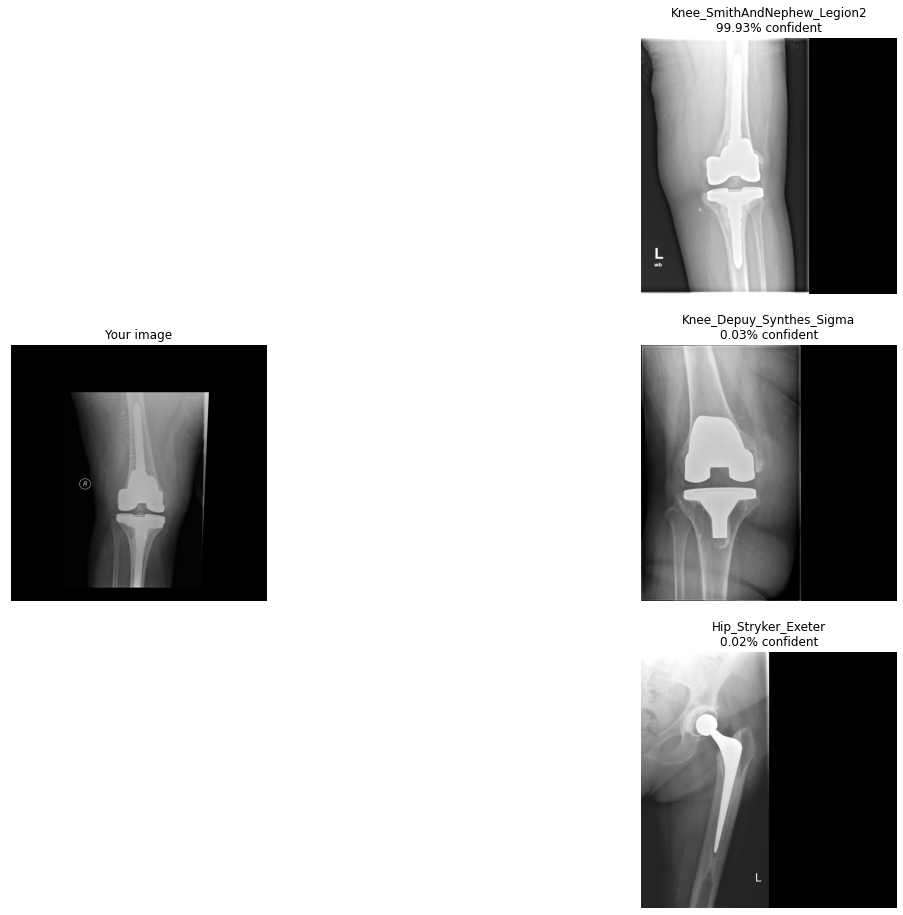

In [14]:
import skimage.io

# Build up an array of example images
example_images = {}
for sample in ds_test.samples:
    example_images[sample['labels']] = sample['filenames']

fig, axes = plt.subplots(3,3,figsize=(16,16))

for r in axes:
    for c in r:
        c.axis('off')

axes[1,0].imshow(img, cmap='gray')
axes[1,0].set_title("Your image")
axes[1,0].axis('off')

class0_path = os.path.join(DATA_PATH, example_images[CLASSES[top_3_classes[0]]])
axes[0,2].imshow(skimage.io.imread(class0_path), cmap='gray')
axes[0,2].set_title(f"{CLASSES[top_3_classes[0]]}\n{top_3_confidences[0]*100:.2f}% confident")

class1_path = os.path.join(DATA_PATH, example_images[CLASSES[top_3_classes[1]]])
axes[1,2].imshow(skimage.io.imread(class1_path), cmap='gray')
axes[1,2].set_title(f"{CLASSES[top_3_classes[1]]}\n{top_3_confidences[1]*100:.2f}% confident")

class2_path = os.path.join(DATA_PATH, example_images[CLASSES[top_3_classes[2]]])
axes[2,2].imshow(skimage.io.imread(class2_path), cmap='gray')
axes[2,2].set_title(f"{CLASSES[top_3_classes[2]]}\n{top_3_confidences[2]*100:.2f}% confident")